In [ ]:
"""
examines catA-v3 versus covref4 alignments
"""


In [1]:
pip install pysam

    100% |████████████████████████████████| 10.0MB 227kB/s ta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [39]:
import pysam
from collections import defaultdict

import seaborn as sns
import pandas as pd
import matplotlib.pylab as plt

In [69]:
assemblies="catA-v3"
sam = pysam.AlignmentFile("%s-vs-covref4.sam" %assemblies)

divs = []
alns = dict()
best_aln_score_per_query = dict()
alns_query = defaultdict(list)
for aln in sam.fetch():
    query_name = aln.query_name
    ref_name = aln.reference_name
    if aln.has_tag('AS'):
        alignment_score = int(aln.get_tag('AS'))
    else:
        alignment_score = None
        print(query_name,ref_name,"no AS")
    if aln.has_tag('de'):
        div  = float(aln.get_tag('de'))
    else:
        div = None
        print(query_name,ref_name,"no de")
    #print(query_name,ref_name,alns,div)
    
    if div is None: continue
        
    # keep all alignments
    # divs += [(div,query_name,ref_name,alignment_score)]

    # record the best alignment per query
    if query_name not in best_aln_score_per_query:
        best_aln_score_per_query[query_name] = (div,query_name,ref_name,alignment_score)
    else:
        d,q,r,a = best_aln_score_per_query[query_name]
        #if d < div: 
        # only update if better alignment score
        if alignment_score > a: 
             best_aln_score_per_query[query_name] = (div,query_name,ref_name,alignment_score)
    
    alns[(query_name,ref_name)] = aln
    alns_query[query_name] += [ref_name]
    #print(aln)
    #break

divs = best_aln_score_per_query.values()
print(divs)
print(sorted(divs))

# analysis of the worst contig, the one which aligns with worst div
most_distant = sorted(divs)[-1]
div,q,r,a = most_distant
print("best alignment of worst query:",alns[(q,r)])
print("all alignments of worst query")
for r2 in alns_query[q]:
    print(alns[(q,r2)])
    


SRR10873981 None no AS
SRR10873981 None no de
SRR10873977 None no AS
SRR10873977 None no de
dict_values([(9.999999747378752e-05, 'SRR7287609', 'MK142676.1', 27375), (0.00039999998989515007, 'ERR3013320', 'LT898443.1', 27902), (0.00019999999494757503, 'SRR11939961', 'NC_045512.2', 29754), (0.00019999999494757503, 'SRR12017059', 'NC_045512.2', 29801), (0.00019999999494757503, 'SRR11780077', 'NC_045512.2', 29684), (0.00019999999494757503, 'SRR11622021', 'NC_045512.2', 29753), (0.00019999999494757503, 'SRR11621851', 'NC_045512.2', 29766), (0.0003000000142492354, 'SRR11965895', 'NC_045512.2', 29722), (0.0015999999595806003, 'SRR6713855', 'KU982975.1', 27015), (9.999999747378752e-05, 'SRR1191915', 'NC_019843.3', 30054), (0.0003000000142492354, 'SRR11965888', 'NC_045512.2', 29747), (0.00019999999494757503, 'SRR11779997', 'NC_045512.2', 29783), (0.00019999999494757503, 'SRR12017037', 'NC_045512.2', 29758), (9.999999747378752e-05, 'SRR11549972', 'NC_045512.2', 29818), (0.0006000000284984708, 'S

worst alignment scores
    Assembly  BestAlignmentScore
  ERR4164903                1474
  SRR1522982                6889
  SRR8181896                8005
  SRR9214144                8767
  ERR4018349               10231
  SRR8062425               11919
  SRR7716792               12059
  SRR7716793               12062
  SRR8791646               12230
 SRR10834677               12429
  ERR4181727               15226
 SRR10875068               15401
  SRR7623977               15667
 SRR10873770               15868
 SRR11621817               15895
 SRR11780000               17127
 SRR11621829               17127
  SRR5447135               17585
  SRR9007069               17790
  SRR9007065               17857
  SRR9007067               17860
  SRR9007062               17870
  SRR9007061               17920
  SRR9007064               17930
  SRR7239363               18940
 SRR11621873               19222
 SRR11771957               19332
  SRR9425918               19755
  ERR1303023        

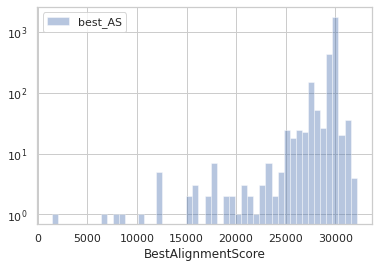

In [70]:
# plot alignment scores
best_alignment_scores = [(query_name,best_aln_score_per_query[query_name][3]) for query_name in best_aln_score_per_query]
#rint(best_alignment_scores)
data_best_alignment_scores= pd.DataFrame(best_alignment_scores, columns=['Assembly', 'BestAlignmentScore'])

sns.set(style="whitegrid")
ax = sns.distplot(data_best_alignment_scores['BestAlignmentScore'], kde=False, label="best_AS")
ax.set_yscale('log')
plt.legend()

print("worst alignment scores")
print(data_best_alignment_scores.sort_values(by=['BestAlignmentScore'])[:30].to_string(index=False))


print(len(data_best_alignment_scores[data_best_alignment_scores['BestAlignmentScore'] <= 24500]),"highly suspicious catA accessions out of",len(data_best_alignment_scores))
data_best_alignment_scores.to_csv('%s-to-covref4.alignment_scores.csv' % assemblies)